In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

In [2]:
# File paths
BASE_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset"
STYLE_CSV = os.path.join(BASE_PATH, "styles.csv")
IMAGE_DIR = os.path.join(BASE_PATH, "images")

# Load styles.csv
df = pd.read_csv(STYLE_CSV, on_bad_lines='skip')
print(f"Initial shape: {df.shape}")
df.head()

Initial shape: (44424, 10)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


2 Data Prep

In [3]:
# Load the styles.csv
csv_path = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv"
df = pd.read_csv(csv_path, on_bad_lines='skip')

# Remove bad rows with missing image IDs
df = df[~df['id'].isna()]
df['id'] = df['id'].astype(int)

# Construct image path
image_folder = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images"
df['image_path'] = df['id'].apply(lambda x: os.path.join(image_folder, f"{x}.jpg"))

# Filter out missing image files
df = df[df['image_path'].apply(os.path.exists)].reset_index(drop=True)

# OPTIONAL: print how many were dropped
print(f"Remaining images: {len(df)}")

Remaining images: 44419


In [4]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoders
le_gender = LabelEncoder()
le_colour = LabelEncoder()
le_season = LabelEncoder()
le_article = LabelEncoder()

# Apply encoding to each target column
df['gender_enc'] = le_gender.fit_transform(df['gender'])
df['colour_enc'] = le_colour.fit_transform(df['baseColour'])
df['season_enc'] = le_season.fit_transform(df['season'])
df['article_enc'] = le_article.fit_transform(df['articleType'])

# Optional: Check number of classes
print("Gender Classes:", list(le_gender.classes_))
print("Colour Classes:", list(le_colour.classes_))
print("Season Classes:", list(le_season.classes_))
print("Article Type Classes:", list(le_article.classes_))

Gender Classes: ['Boys', 'Girls', 'Men', 'Unisex', 'Women']
Colour Classes: ['Beige', 'Black', 'Blue', 'Bronze', 'Brown', 'Burgundy', 'Charcoal', 'Coffee Brown', 'Copper', 'Cream', 'Fluorescent Green', 'Gold', 'Green', 'Grey', 'Grey Melange', 'Khaki', 'Lavender', 'Lime Green', 'Magenta', 'Maroon', 'Mauve', 'Metallic', 'Multi', 'Mushroom Brown', 'Mustard', 'Navy Blue', 'Nude', 'Off White', 'Olive', 'Orange', 'Peach', 'Pink', 'Purple', 'Red', 'Rose', 'Rust', 'Sea Green', 'Silver', 'Skin', 'Steel', 'Tan', 'Taupe', 'Teal', 'Turquoise Blue', 'White', 'Yellow', nan]
Season Classes: ['Fall', 'Spring', 'Summer', 'Winter', nan]
Article Type Classes: ['Accessory Gift Set', 'Baby Dolls', 'Backpacks', 'Bangle', 'Basketballs', 'Bath Robe', 'Beauty Accessory', 'Belts', 'Blazers', 'Body Lotion', 'Body Wash and Scrub', 'Booties', 'Boxers', 'Bra', 'Bracelet', 'Briefs', 'Camisoles', 'Capris', 'Caps', 'Casual Shoes', 'Churidar', 'Clothing Set', 'Clutches', 'Compact', 'Concealer', 'Cufflinks', 'Cushion Co

In [5]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
import os

class FashionDataset(Dataset):
    """
    Custom PyTorch Dataset for multi-label classification of fashion product images.
    
    Returns:
        image: transformed image tensor (3x224x224)
        labels: dictionary containing encoded labels for gender, color, season, articleType
    """
    def __init__(self, dataframe, image_dir, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, f"{row['id']}.jpg")

        # Load image and apply transform
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Labels for 4 tasks
        labels = {
            'gender': torch.tensor(row['gender_enc'], dtype=torch.long),
            'colour': torch.tensor(row['colour_enc'], dtype=torch.long),
            'season': torch.tensor(row['season_enc'], dtype=torch.long),
            'article': torch.tensor(row['article_enc'], dtype=torch.long)
        }

        return image, labels

In [6]:
from torch.utils.data import DataLoader, random_split

# Image preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize to 224x224
    transforms.ToTensor(),                  # Convert to tensor (C x H x W)
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize RGB channels to [-1, 1]
])

# Create full dataset
image_dir = os.path.join(BASE_PATH, "images")
full_dataset = FashionDataset(df, image_dir=image_dir, transform=transform)

# Split into 80% training and 20% validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

print(f"Total images: {len(full_dataset)}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")

Total images: 44419
Training images: 35535
Validation images: 8884


In [7]:
class MultiTaskResNet(nn.Module):
    """
    A CNN model for multi-task classification based on ResNet18.
    
    Shared ResNet backbone outputs a feature vector,
    which is passed through 4 separate classifier heads.
    """
    def __init__(self, num_genders, num_colours, num_seasons, num_articles):
        super(MultiTaskResNet, self).__init__()

        # Load pretrained ResNet18 backbone
        base_model = models.resnet18(pretrained=True)
        num_features = base_model.fc.in_features

        # Remove final FC layer
        self.backbone = nn.Sequential(*list(base_model.children())[:-1])  # Exclude final fc

        # Task-specific heads
        self.gender_head = nn.Linear(num_features, num_genders)
        self.colour_head = nn.Linear(num_features, num_colours)
        self.season_head = nn.Linear(num_features, num_seasons)
        self.article_head = nn.Linear(num_features, num_articles)

    def forward(self, x):
        # Shared backbone
        x = self.backbone(x)  # Output shape: (B, num_features, 1, 1)
        x = x.view(x.size(0), -1)  # Flatten to (B, num_features)

        # Pass through each head
        gender_out = self.gender_head(x)
        colour_out = self.colour_head(x)
        season_out = self.season_head(x)
        article_out = self.article_head(x)

        return {
            'gender': gender_out,
            'colour': colour_out,
            'season': season_out,
            'article': article_out
        }

In [8]:
# Number of classes for each task
num_genders = len(le_gender.classes_)
num_colours = len(le_colour.classes_)
num_seasons = len(le_season.classes_)
num_articles = len(le_article.classes_)

# Instantiate model
model = MultiTaskResNet(num_genders, num_colours, num_seasons, num_articles)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model initialized on:", device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 158MB/s] 


Model initialized on: cuda


In [9]:
# One CrossEntropyLoss per output
criterion = nn.CrossEntropyLoss()

# Use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [10]:
def calculate_accuracy(preds, labels):
    """
    Compute accuracy by comparing argmax predictions to ground truth labels.
    """
    pred_classes = torch.argmax(preds, dim=1)
    correct = (pred_classes == labels).sum().item()
    total = labels.size(0)
    return correct / total


In [11]:
EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    gender_acc, colour_acc, season_acc, article_acc = 0.0, 0.0, 0.0, 0.0
    total_samples = 0

    for images, labels in train_loader:
        images = images.to(device)
        gender_labels = labels['gender'].to(device)
        colour_labels = labels['colour'].to(device)
        season_labels = labels['season'].to(device)
        article_labels = labels['article'].to(device)

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss_gender = criterion(outputs['gender'], gender_labels)
        loss_colour = criterion(outputs['colour'], colour_labels)
        loss_season = criterion(outputs['season'], season_labels)
        loss_article = criterion(outputs['article'], article_labels)

        total_loss = loss_gender + loss_colour + loss_season + loss_article

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Track loss & accuracy
        running_loss += total_loss.item()
        total_samples += images.size(0)

        gender_acc += calculate_accuracy(outputs['gender'], gender_labels) * images.size(0)
        colour_acc += calculate_accuracy(outputs['colour'], colour_labels) * images.size(0)
        season_acc += calculate_accuracy(outputs['season'], season_labels) * images.size(0)
        article_acc += calculate_accuracy(outputs['article'], article_labels) * images.size(0)

    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {running_loss/len(train_loader):.4f}")
    print(f"  Gender Acc:  {gender_acc/total_samples:.4f}")
    print(f"  Colour Acc:  {colour_acc/total_samples:.4f}")
    print(f"  Season Acc:  {season_acc/total_samples:.4f}")
    print(f"  Article Acc: {article_acc/total_samples:.4f}")

Epoch [1/10] - Loss: 3.6748
  Gender Acc:  0.8763
  Colour Acc:  0.6001
  Season Acc:  0.6983
  Article Acc: 0.7572
Epoch [2/10] - Loss: 2.2666
  Gender Acc:  0.9284
  Colour Acc:  0.7041
  Season Acc:  0.7782
  Article Acc: 0.8697
Epoch [3/10] - Loss: 1.7546
  Gender Acc:  0.9489
  Colour Acc:  0.7535
  Season Acc:  0.8264
  Article Acc: 0.9074
Epoch [4/10] - Loss: 1.3160
  Gender Acc:  0.9673
  Colour Acc:  0.8088
  Season Acc:  0.8761
  Article Acc: 0.9361
Epoch [5/10] - Loss: 0.9308
  Gender Acc:  0.9793
  Colour Acc:  0.8643
  Season Acc:  0.9198
  Article Acc: 0.9582
Epoch [6/10] - Loss: 0.6156
  Gender Acc:  0.9893
  Colour Acc:  0.9130
  Season Acc:  0.9585
  Article Acc: 0.9745
Epoch [7/10] - Loss: 0.4033
  Gender Acc:  0.9929
  Colour Acc:  0.9474
  Season Acc:  0.9773
  Article Acc: 0.9860
Epoch [8/10] - Loss: 0.2852
  Gender Acc:  0.9959
  Colour Acc:  0.9665
  Season Acc:  0.9841
  Article Acc: 0.9918
Epoch [9/10] - Loss: 0.2223
  Gender Acc:  0.9967
  Colour Acc:  0.9736


In [12]:
model.eval()

MultiTaskResNet(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [13]:
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F

def predict_attributes(image_path, model, class_maps):
    """
    Predict gender, colour, season, articleType for a given image.
    """
    # Preprocess the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(input_tensor)
    
    # Decode predictions using class_maps
    predictions = {}
    for task in ['gender', 'colour', 'season', 'article']:
        probs = F.softmax(outputs[task], dim=1)
        pred_class_idx = torch.argmax(probs, dim=1).item()
        class_label = class_maps[task][pred_class_idx]
        predictions[task] = class_label
    
    return predictions

In [16]:
print(df.columns.tolist())

['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image_path', 'gender_enc', 'colour_enc', 'season_enc', 'article_enc']


In [17]:
class_maps = {
    'gender': dict(df[['gender_enc', 'gender']].drop_duplicates().values),
    'colour': dict(df[['colour_enc', 'baseColour']].drop_duplicates().values),
    'season': dict(df[['season_enc', 'season']].drop_duplicates().values),
    'article': dict(df[['article_enc', 'articleType']].drop_duplicates().values)
}

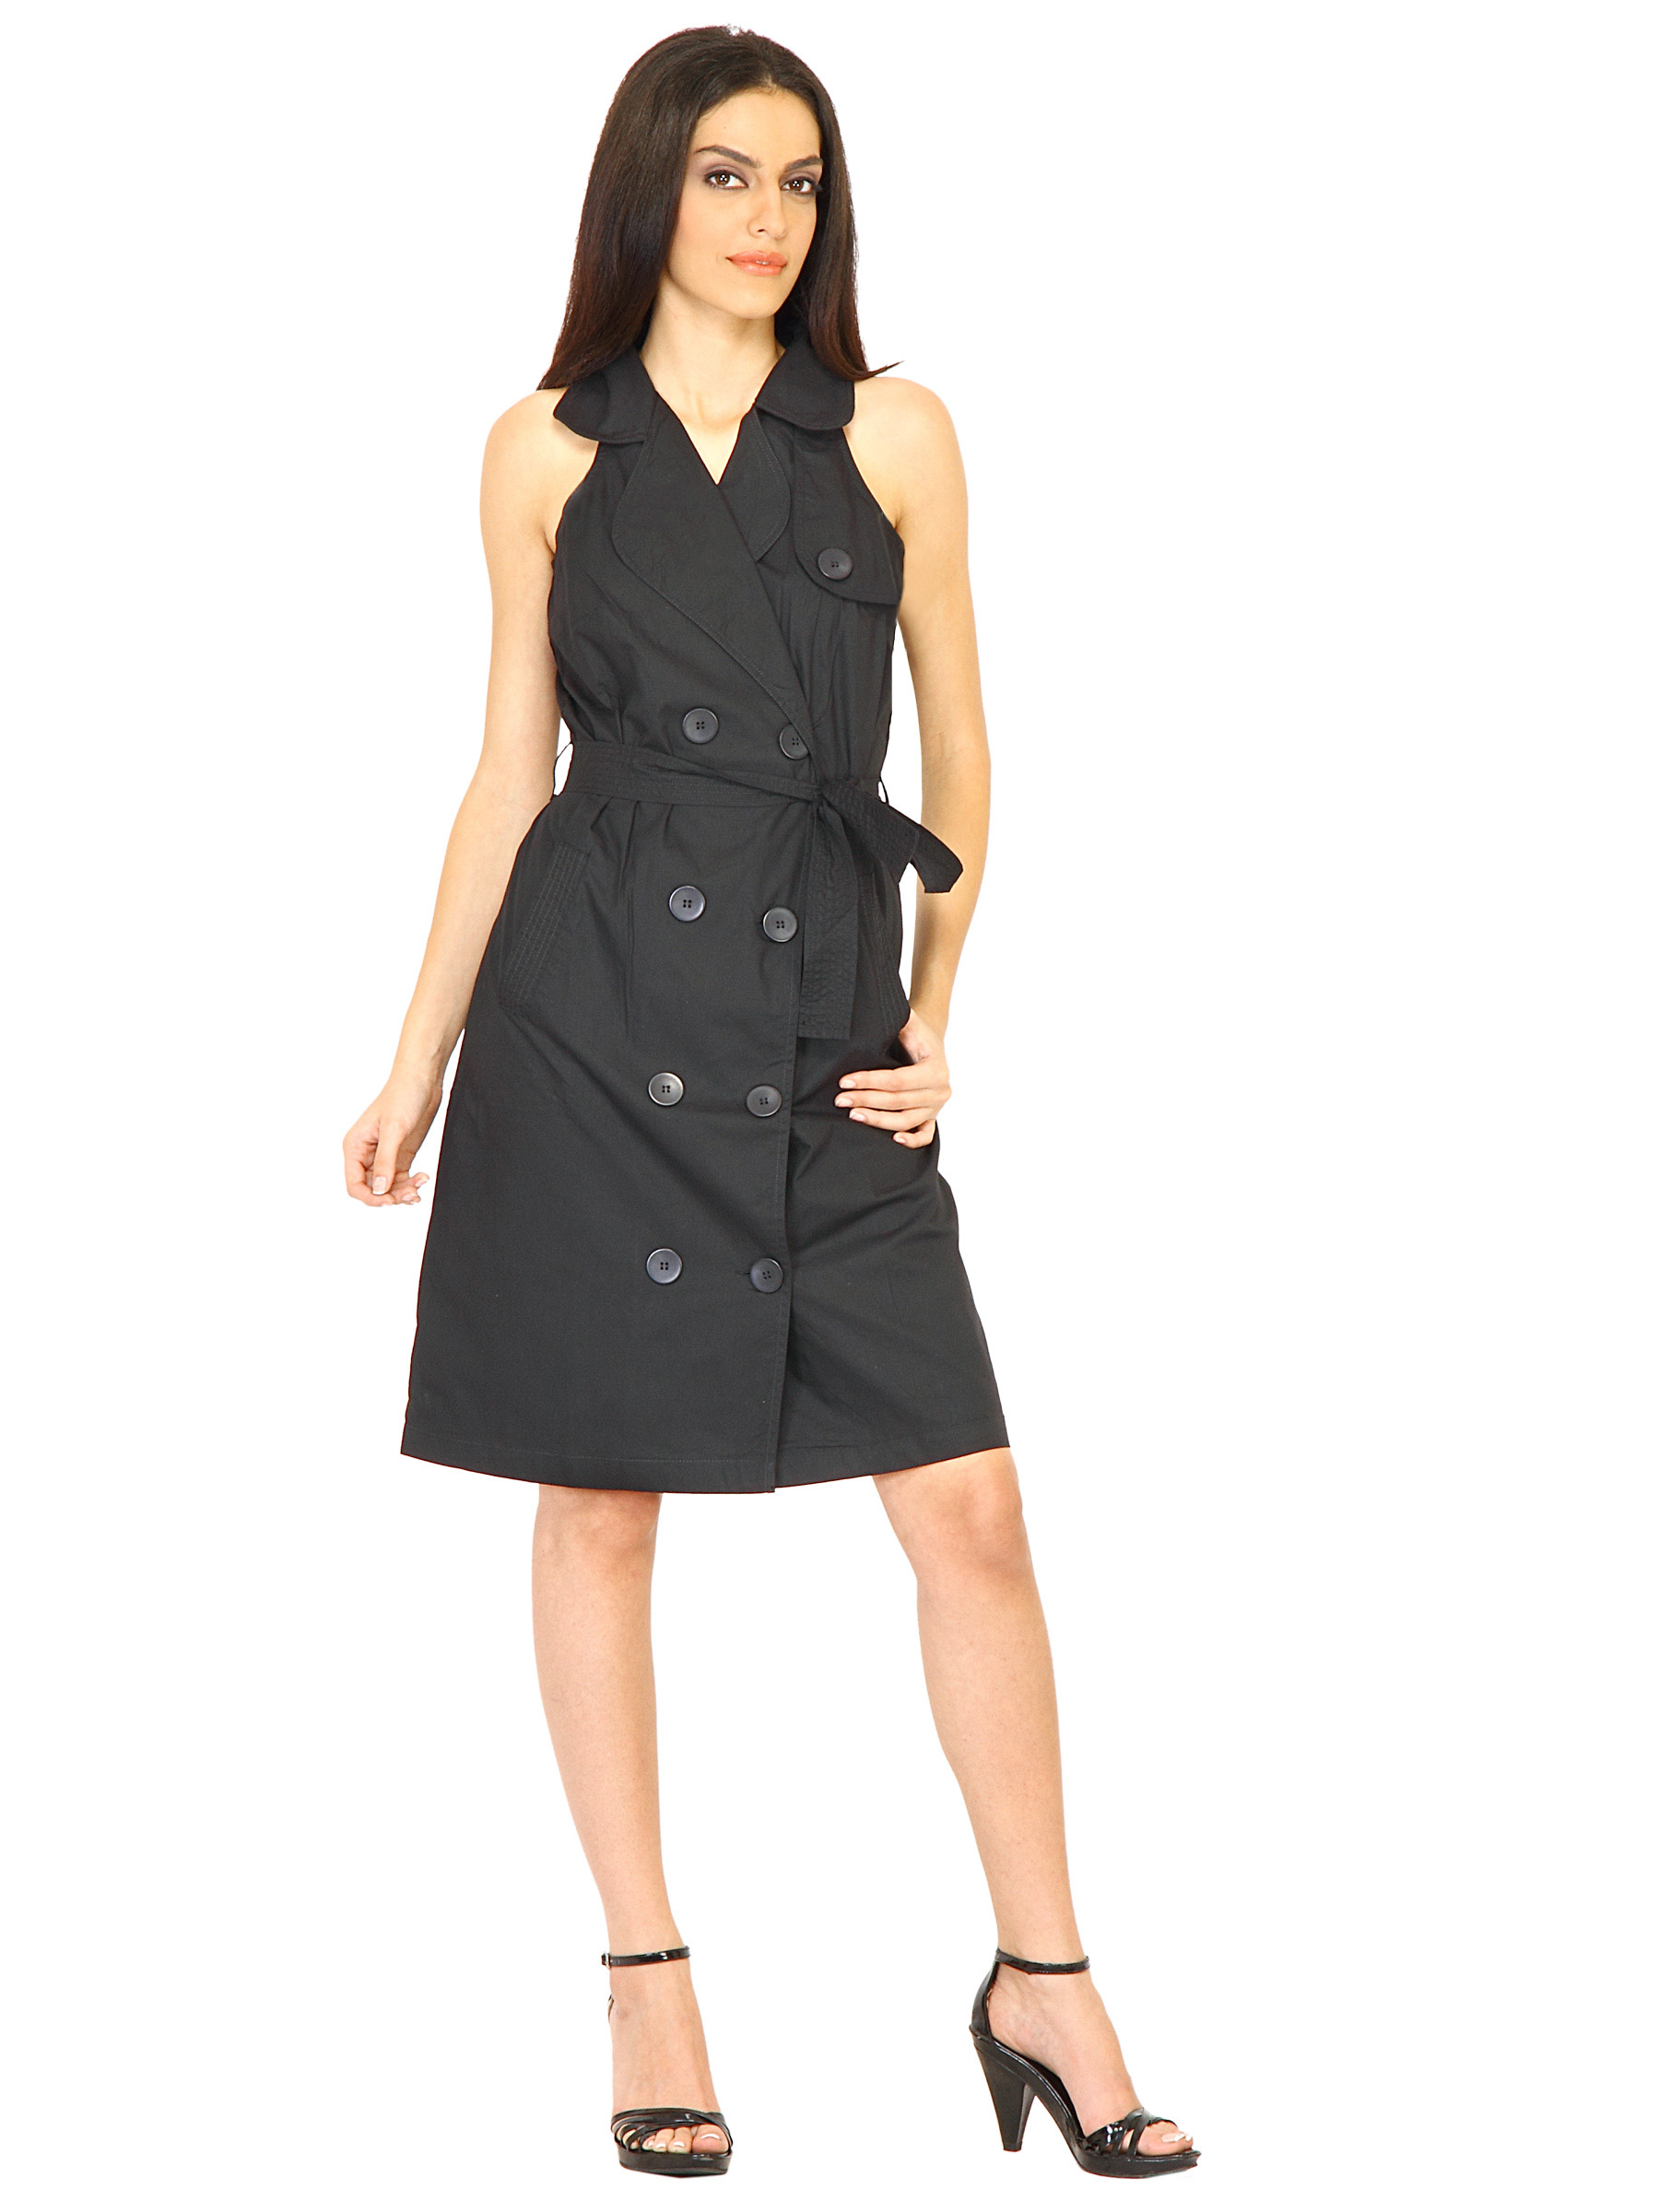

=== Predicted Attributes ===
Gender: Women
Colour: Black
Season: Spring
Article: Kajal and Eyeliner

=== True Attributes ===
Gender: Women
Colour: White
Season: Summer
Article: Skirts


In [22]:
# Choose a test image
image_path = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/10360.jpg"

# Make prediction
preds = predict_attributes(image_path, model, class_maps)

# Extract true labels
true_row = df[df['image_path'].str.endswith("10000.jpg")].iloc[0]

true_labels = {
    'gender': class_maps['gender'][true_row['gender_enc']],
    'colour': class_maps['colour'][true_row['colour_enc']],
    'season': class_maps['season'][true_row['season_enc']],
    'article': class_maps['article'][true_row['article_enc']]
}

# Display image and results
from IPython.display import Image as IPyImage, display
display(IPyImage(filename=image_path))

print("=== Predicted Attributes ===")
for k, v in preds.items():
    print(f"{k.capitalize()}: {v}")

print("\n=== True Attributes ===")
for k, v in true_labels.items():
    print(f"{k.capitalize()}: {v}")

In [23]:
import os
MODEL_SAVE_PATH = "/kaggle/working/multilabel_fashion_model.pth"

# Save the full model (includes weights and architecture)
torch.save({
    'model_state_dict': model.state_dict(),
    'class_maps': class_maps
}, MODEL_SAVE_PATH)

print(f"Model saved to {MODEL_SAVE_PATH}")

Model saved to /kaggle/working/multilabel_fashion_model.pth
